## I need to correctly classify images of cats and dogs. They are images so the best way is to use CNN, and for that I need a GPU and on Kaggle is for free

In [1]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import cv2
import matplotlib.pyplot as plt
import random
random.seed(42)

### set folder, categories and image size that I want to use

In [2]:
file_dir = '/kaggle/input/cats-and-dogs/PetImages/'

categories = ['Cat', 'Dog']

IMG_SIZE = 128

### import all the images and put them in a list with the category

In [3]:
data = []

for category in categories:
    path = os.path.join(file_dir, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        if os.path.getsize(img_path) > 0:
            label = categories.index(category)
            arr = cv2.imread(img_path)
            if arr is not None:
                new_arr = cv2.resize(arr, (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_AREA)
                data.append([new_arr, label])
            

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


In [4]:
random.shuffle(data)

### to arrive at 90% of accuracy I need some augmented data so I prepare the process for that

In [ ]:
import imgaug.augmenters as iaa

augmentation = iaa.Sequential([
    # 1. Flip
    iaa.Sometimes(0.2, iaa.Fliplr(0.5)),
    iaa.Sometimes(0.2, iaa.Flipud(0.5)),
    # 2. Affine
    iaa.Sometimes(0.2, iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
               rotate=(-30, 30),
               scale=(0.5, 1.5))),
    # 3. Multiply
    iaa.Sometimes(0.2, iaa.Multiply((0.8, 1.2))),
    # 4. Linearcontrast
    iaa.Sometimes(0.2, iaa.LinearContrast((0.6, 1.4))),
    # Perform methods below only sometimes
    iaa.Sometimes(0.2,
        # 5. GaussianBlur
        iaa.GaussianBlur((0.0, 3.0))
        )
])

### reorganize data in separate NP arrays

In [ ]:
X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)
    
X = np.array(X)
y = np.array(y)

In [ ]:
X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [ ]:
print('cats images: ' + str(np.count_nonzero(y == 0)))
print('dogs images: ' + str(np.count_nonzero(y == 1)))

cats images: 12476
dogs images: 12470


### the two categories ara balanced so I can contine

### the data are all togheter so I separate them in train, val and test set. On the test I'll check the accuracy, precisio, recall and f1

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.3, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, stratify=y_tmp)

In [ ]:
size_before_aug = len(X_train)

print('train data before augmentation: ' + str(size_before_aug))

train data before augmentation: 17462


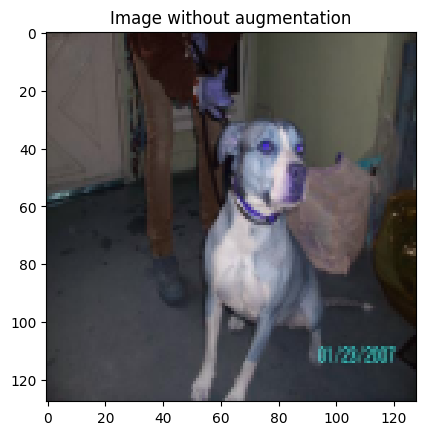

In [ ]:
plt.imshow(X_train[1], interpolation='nearest')
plt.title('Image without augmentation')
plt.show()

### import tensorflow and prepare the model structure

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Rescaling

In [ ]:
model = Sequential()

model.add(Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3))),

model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2)) # important to not overfit and increase generalization

model.add(Conv2D(96, (3,3), activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2)) 

model.add(Conv2D(128, (3,3), activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2)) 

model.add(Conv2D(128, (3,3), activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2)) 

model.add(Conv2D(128, (3,3), activation = 'relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())

model.add(Dense(96, activation='relu'))

model.add(Dense(2, activation = 'softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 512,514 (1.96 MB)

 Trainable params: 512,514 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

### train the model

In [ ]:
model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
 12/546 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.5222 - loss: 0.8433  

I0000 00:00:1709761456.331086     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


546/546 ━━━━━━━━━━━━━━━━━━━━ 32s 35ms/step - accuracy: 0.5275 - loss: 0.7001 - val_accuracy: 0.5903 - val_loss: 0.6631
Epoch 2/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.6280 - loss: 0.6436 - val_accuracy: 0.6927 - val_loss: 0.5875
Epoch 3/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.6983 - loss: 0.5768 - val_accuracy: 0.6873 - val_loss: 0.5983
Epoch 4/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.7391 - loss: 0.5249 - val_accuracy: 0.7392 - val_loss: 0.5300
Epoch 5/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.7793 - loss: 0.4720 - val_accuracy: 0.7937 - val_loss: 0.4420
Epoch 6/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8079 - loss: 0.4233 - val_accuracy: 0.8036 - val_loss: 0.4384
Epoch 7/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8299 - loss: 0.3743 - val_accuracy: 0.8378 - val_loss: 0.3714
Epoch 8/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8502 - loss: 0.3416 - val_accuracy: 0.82

### predict the results of the test set (data never saw from the model)

In [ ]:
pred = model.predict(X_test)

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


### extract the max and put if 0 or 1

In [ ]:
pred = np.argmax(pred, axis=1)
pred

array([0, 0, 1, ..., 0, 0, 1])

### calculate the accuracy etc. on the test set

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
print('without augmentation')
y_real = y_test
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_real, pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_real, pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_real, pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_real, pred)
print('F1 score: %f' % f1)

without augmentation
Accuracy: 0.886692
Precision: 0.918403
Recall: 0.848663
F1 score: 0.882157


### augment the data and train the model

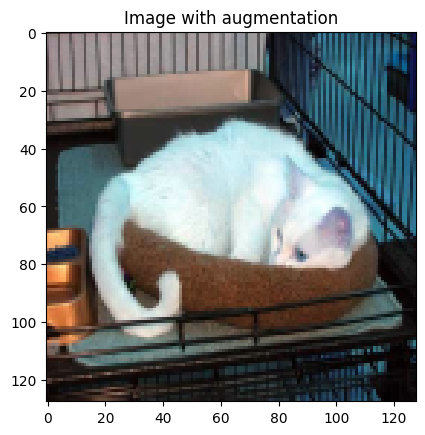

In [ ]:
for i in range(size_before_aug):
    augmented_image = augmentation(image=X_train[i])
    augmented_image = augmented_image.reshape(1, IMG_SIZE, IMG_SIZE, 3)
    plt.imshow(augmented_image[0], interpolation='nearest')
    plt.title('Image with augmentation')
    plt.show()
    break;

In [ ]:
for i in range(0, size_before_aug, 12):
    augmented_image = augmentation(image=X_train[i])
    augmented_image = augmented_image.reshape(1, IMG_SIZE, IMG_SIZE, 3)
    X_train = np.append(X_train, augmented_image, axis=0)
    y_train = np.append(y_train, y_train[i])

In [ ]:
print('train data after augmentation: ' + str(len(X_train)))

train data after augmentation: 18918


In [25]:
model_aug = Sequential()

model_aug.add(Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3))),

model_aug.add(Conv2D(64, (3,3), activation = 'relu'))
model_aug.add(MaxPooling2D((2,2)))
model_aug.add(Dropout(0.2)) # important to not overfit and increase generalization

model_aug.add(Conv2D(96, (3,3), activation = 'relu'))
model_aug.add(MaxPooling2D((2,2)))
model_aug.add(Dropout(0.2)) 

model_aug.add(Conv2D(128, (3,3), activation = 'relu'))
model_aug.add(MaxPooling2D((2,2)))
model_aug.add(Dropout(0.2)) 

model_aug.add(Conv2D(128, (3,3), activation = 'relu'))
model_aug.add(MaxPooling2D((2,2)))
model_aug.add(Dropout(0.2)) 

model_aug.add(Conv2D(128, (3,3), activation = 'relu'))
model_aug.add(MaxPooling2D((2,2)))

model_aug.add(Flatten())

model_aug.add(Dense(96, activation='relu'))

model_aug.add(Dense(2, activation = 'softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
model_aug.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [27]:
model_aug.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
592/592 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - accuracy: 0.5375 - loss: 0.6838 - val_accuracy: 0.6956 - val_loss: 0.5793
Epoch 2/20
592/592 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.7027 - loss: 0.5697 - val_accuracy: 0.7501 - val_loss: 0.5052
Epoch 3/20
592/592 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.7575 - loss: 0.5060 - val_accuracy: 0.7734 - val_loss: 0.4724
Epoch 4/20
592/592 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8036 - loss: 0.4259 - val_accuracy: 0.8362 - val_loss: 0.3688
Epoch 5/20
592/592 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8315 - loss: 0.3736 - val_accuracy: 0.8284 - val_loss: 0.3700
Epoch 6/20
592/592 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8618 - loss: 0.3243 - val_accuracy: 0.8648 - val_loss: 0.3193
Epoch 7/20
592/592 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8761 - loss: 0.2920 - val_accuracy: 0.8666 - val_loss: 0.3220
Epoch 8/20
592/592 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8972 - loss: 0.2503 - val_acc

In [28]:
pred = model_aug.predict(X_test)
pred = np.argmax(pred, axis=1)

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


### check performance

In [29]:
print('with augmentation')
y_real = y_test
# accuracy: (tp + tn) / (p + n)
accuracy_aug = accuracy_score(y_real, pred)
print('Accuracy: %f' % accuracy_aug)
# precision tp / (tp + fp)
precision_aug = precision_score(y_real, pred)
print('Precision: %f' % precision_aug)
# recall: tp / (tp + fn)
recall_aug = recall_score(y_real, pred)
print('Recall: %f' % recall_aug)
# f1: 2 tp / (2 tp + fp + fn)
f1_aug = f1_score(y_real, pred)
print('F1 score: %f' % f1)

with augmentation
Accuracy: 0.908071
Precision: 0.921547
Recall: 0.891979
F1 score: 0.882157


In [31]:
model_aug.save('/kaggle/working/my_model.h5')

In [32]:
model_saved = tf.keras.models.load_model('/kaggle/working/my_model.h5')

# Check its architecture
model_saved.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 61, 61, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 30, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 512,516 (1.96 MB)

 Trainable params: 512,514 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)